<a href="https://colab.research.google.com/github/hoangthuha/researchproject/blob/main/Project_B_Full_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

from torch.nn.modules.activation import ReLU
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
torch.manual_seed(42)
import statistics as st

#2 - Read the Dataset

In [ ]:
# Mount Google Drive to access all files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/DS Capstone/Dataset/RFLFSODataFull.csv"

In [ ]:
full_data = pd.read_csv("/content/drive/MyDrive/DS Capstone/Dataset/RFLFSODataFull.csv")
print("Full_data shape:",full_data.shape)

Full_data shape: (91379, 27)


In [ ]:
full_data

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,7.913289,6.927868,17.595709,17.615907,17.340148,2115.338398,83500000000,0.000000,0.000000,0.000000,...,26.603030,24.680849,9,65884.518460,72336.362233,65617.543754,88.755450,3.057066,6.863808,3.007939
1,7.451176,4.412096,17.549693,17.572415,17.299439,2113.999257,73500000000,0.000000,0.000000,0.000000,...,26.377164,24.313108,9,64963.410920,68753.386153,60379.327485,99.790057,2.727910,6.468903,2.537393
2,7.072747,6.268740,17.290230,17.644014,16.037894,2118.689047,83500000000,0.000000,0.000000,0.000000,...,27.670822,23.150277,10,54794.281070,54821.773817,50850.155963,65.730085,1.674810,2.826916,1.640809
3,6.949288,4.317853,16.820880,17.066776,15.895622,2114.632339,73500000000,0.000000,0.000000,0.000000,...,26.522100,23.174815,10,50205.641590,52519.927530,45374.510898,88.127497,0.962068,2.780643,0.886951
4,7.361052,6.114514,16.813820,17.953974,15.227225,2116.786055,83500000000,0.000000,0.000000,0.000000,...,26.305736,24.864100,10,59038.325990,64418.329138,54461.246506,84.167414,1.881007,4.476298,1.874052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91374,9.150012,11.968291,23.283256,24.142871,22.169805,3970.846129,83500000000,0.000000,0.000000,0.000000,...,27.257926,26.013205,4,13041.847800,13458.340663,12411.852994,91.391749,0.000000,0.027596,0.000000
91375,9.333777,11.538030,23.259618,25.104895,21.005496,3969.230652,73500000000,0.000000,0.000000,0.000000,...,28.101044,25.032282,4,15959.633590,16232.735439,15345.485232,47.997946,0.075640,0.349551,0.069834
91376,8.873168,11.491891,23.331697,23.996130,22.148649,3968.373512,83500000000,0.000000,0.000000,0.000000,...,28.249678,26.205773,4,13129.663750,13948.560177,11925.979953,103.963102,0.052282,0.178062,0.049824
91377,9.538886,11.526529,21.241027,21.624932,20.736391,3967.550165,73500000000,29.693160,30.761540,28.497137,...,26.880084,25.031934,5,15082.787860,15522.762221,14842.654291,82.090779,0.443520,1.838449,0.413146


In [ ]:
full_data.columns

Index(['FSO_Att', 'RFL_Att', 'AbsoluteHumidity', 'AbsoluteHumidityMax',
       'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate',
       'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax',
       'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature',
       'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time',
       'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection',
       'WindSpeed', 'WindSpeedMax', 'WindSpeedMin'],
      dtype='object')

In [ ]:
full_data['SYNOPCode'].unique()

array([0, 6, 8, 5, 3, 4, 7])

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import r_regression
def get_mutual_info_and_correlation(rfl_att_df, fso_att_df):
    rfl_att_values = rfl_att_df.values.reshape(-1,1)
    fso_att_values = fso_att_df.values.reshape(-1,1)

    m = mutual_info_regression(rfl_att_values, fso_att_values, random_state=0)[0]
    # print('mutual info ', m)

    r = r_regression(rfl_att_values, fso_att_values)[0]
    # print('r ', r)

    return m, r


def draw_2d_histogram(rfl_att_df,fso_att_df, synop_code, bin_count, title):
    H, xedges, yedges = np.histogram2d(rfl_att_df.values, fso_att_df.values, bins= bin_count, range=  np.column_stack(([0,0],[50,50])))
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(131, title= title)
    plt.imshow(H.T, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.xlabel('RFL Attenuation')
    plt.ylabel('FSO Attenuation')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Counts')
    plt.show()

def get_title(synop_code):
    if synop_code == 0:
        return 'Clear'
    elif synop_code == 3:
        return 'Dust storm'
    elif synop_code == 4:
        return 'Fog'
    elif synop_code == 5:
        return 'Drizzle'
    elif synop_code == 6:
        return 'Rain'
    elif synop_code == 7:
        return 'Snow'
    elif synop_code == 8:
        return 'Showers'
    else:
        return ''

def draw_2d_histograms(df, synop_codes):
    results = []
    for synop_code in synop_codes:
        synop_df = df[df['SYNOPCode'] == synop_code]
        rfl_att_df = synop_df['RFL_Att']
        fso_att_df = synop_df['FSO_Att']
        mutual_info, r_square = get_mutual_info_and_correlation(rfl_att_df, fso_att_df)
        results.append({'synop_code' : synop_code, 'mutual_info' : mutual_info, 'r': r_square, 'title': get_title(synop_code)})
        title = get_title(synop_code) #+ ' synop code - ' + str(synop_code)
        draw_2d_histogram(rfl_att_df, fso_att_df, synop_code, 50, title)

    return results

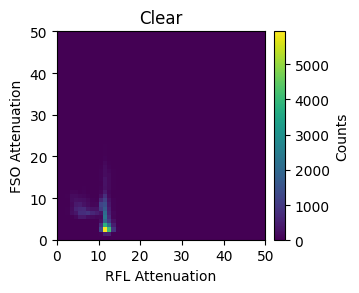

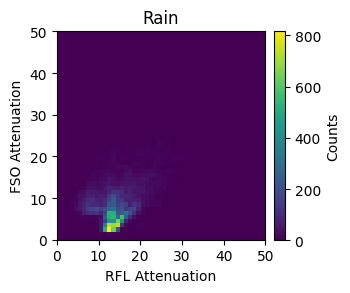

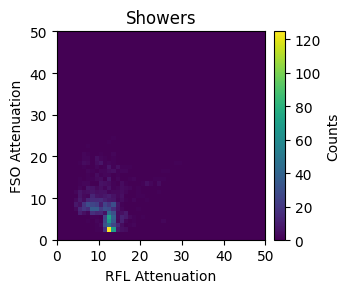

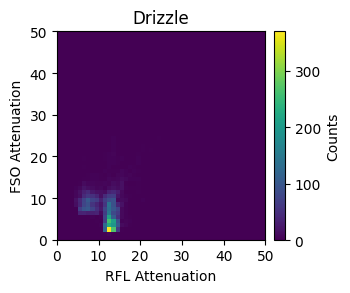

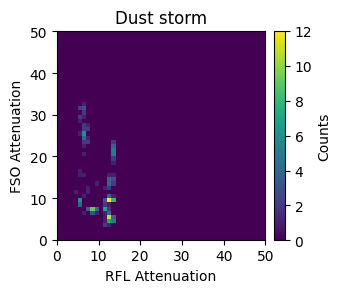

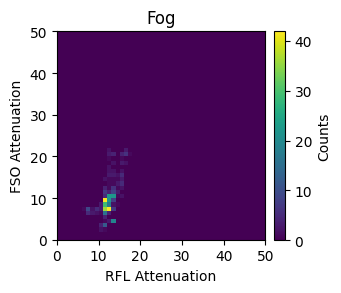

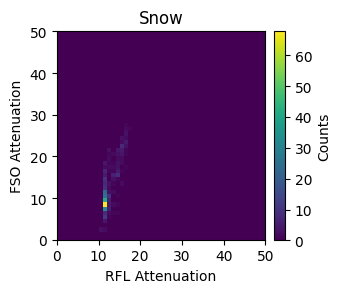

,synop_code,mutual_info,r,title
0,0,0.344074,-0.267705,Clear
1,6,0.367223,0.348307,Rain
2,8,0.458903,-0.169827,Showers
3,5,0.385054,-0.155631,Drizzle
4,3,0.834986,-0.424294,Dust storm
5,4,0.716927,0.577887,Fog
6,7,0.529686,0.804480,Snow


In [ ]:
synop_codes = full_data['SYNOPCode'].unique()
# synop_codes = [0]
results = draw_2d_histograms(full_data, synop_codes)
results_df = pd.DataFrame(results)
results_df

In [ ]:
x_values = list(results_df['title'].values)
x_values

['Clear', 'Rain', 'Showers', 'Drizzle', 'Dust storm', 'Fog', 'Snow']

In [ ]:
mi = list(results_df['mutual_info'])
mi

[0.3440737855669216,
 0.36722282401850137,
 0.4589028374121864,
 0.38505376861606244,
 0.8349861940819236,
 0.7169274697109875,
 0.5296859967017329]

In [ ]:
r_positive = []
r_negative = []
for i, row in results_df.iterrows():
    r2 = row['r']
    if r2 > 0:
        r_positive.append(r2)
        r_negative.append(0)
    else:
        r_negative.append(abs(r2))
        r_positive.append(0)

print('r_positives ', r_positive)
print('r_negative ', r_negative)


r_positives  [0, 0.3483071226482183, 0, 0, 0, 0.5778874628028899, 0.8044796172355829]
r_negative  [0.26770528955596845, 0, 0.1698272545438924, 0.15563138456362885, 0.42429432822813856, 0, 0]


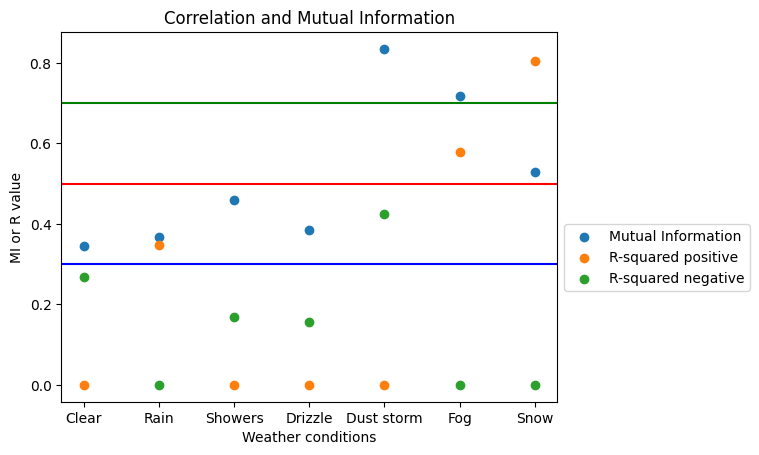

In [ ]:
ax = plt.subplot()
ax.scatter(x_values, mi)
ax.scatter(x_values, r_positive)
ax.scatter(x_values, r_negative)
# ax.legend(labels=['Mutual Information', 'R-squared positive', 'R-squared negative'], loc='best', prop={'size':8.5})
ax.axhline(y=0.7, color='g')
ax.axhline(y=0.5, color='r')
ax.axhline(y=0.3, color='b')
plt.title('Correlation and Mutual Information')
plt.xlabel('Weather conditions')
plt.ylabel('MI or R value')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
ax.legend(labels=['Mutual Information', 'r positive', 'r negative'], loc='upper left', bbox_to_anchor=(1,0.5))
plt.show()

# 3 - Data Preprocessing

In [ ]:
def process_data(process_df):
    # Change unit of Frequency to GHz
    process_df['Frequency'] = process_df['Frequency'] / 10000000000

    # Encode SYNOP Code column
    process_df = pd.concat([process_df, pd.get_dummies(process_df["SYNOPCode"], prefix="SYNOP")], axis=1)
    process_df.drop("SYNOPCode", axis = 1, inplace = True)
    process_df = process_df.dropna()

    return process_df

In [ ]:
# def get_x_y(file_path):
#     df = pd.read_csv(file_path)
#     target_columns = ["FSO_Att", "RFL_Att"]
#     y = df[target_columns]
#     x = df.drop(columns=target_columns)
#     return x,y

# X,y = get_x_y(file_path)


# 4 - Methodologies

In [ ]:
full_data = process_data(full_data)

In [ ]:
y = full_data[["FSO_Att","RFL_Att"]]
y.head()

,FSO_Att,RFL_Att
0,7.913289,6.927868
1,7.451176,4.412096
2,7.072747,6.268740
3,6.949288,4.317853
4,7.361052,6.114514


In [ ]:
X = full_data.drop(columns = ["FSO_Att","RFL_Att"])
X.head()

,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,RainIntensity,RainIntensityMax,...,WindSpeed,WindSpeedMax,WindSpeedMin,SYNOP_0,SYNOP_3,SYNOP_4,SYNOP_5,SYNOP_6,SYNOP_7,SYNOP_8
0,17.595709,17.615907,17.340148,2115.338398,8.35,0.0,0.0,0.0,0.0,0.0,...,3.057066,6.863808,3.007939,1,0,0,0,0,0,0
1,17.549693,17.572415,17.299439,2113.999257,7.35,0.0,0.0,0.0,0.0,0.0,...,2.727910,6.468903,2.537393,1,0,0,0,0,0,0
2,17.290230,17.644014,16.037894,2118.689047,8.35,0.0,0.0,0.0,0.0,0.0,...,1.674810,2.826916,1.640809,1,0,0,0,0,0,0
3,16.820880,17.066776,15.895622,2114.632339,7.35,0.0,0.0,0.0,0.0,0.0,...,0.962068,2.780643,0.886951,1,0,0,0,0,0,0
4,16.813820,17.953974,15.227225,2116.786055,8.35,0.0,0.0,0.0,0.0,0.0,...,1.881007,4.476298,1.874052,1,0,0,0,0,0,0


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=0)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size = 0.25, shuffle=True, random_state=0)

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_validation_df = X_train_validation.copy()
X_test_df = X_test.copy()

X_train = feature_scaler.fit_transform(X_train)
X_validation = feature_scaler.transform(X_validation)
X_test = feature_scaler.transform(X_test)
X_train_validation = feature_scaler.fit_transform(X_train_validation)

y_train = target_scaler.fit_transform(y_train)

print('X_train ', X_train.shape)
print('X_validation ', X_validation.shape)
print('X_test ', X_test.shape)
print('y_train ', y_train.shape)
print('y_validation ', y_validation.shape)
print('y_test ', y_test.shape)

X_train  (54827, 31)
X_validation  (18276, 31)
X_test  (18276, 31)
y_train  (54827, 2)
y_validation  (18276, 2)
y_test  (18276, 2)


In [ ]:
# print('X_train: ', X_train.shape)
# print('X_test: ', X_test.shape)
# print('y_train: ', y_train.shape)
# print('y_test: ', y_test.shape)

In [ ]:
y_train_FSO = y_train_validation["FSO_Att"]
y_train_FSO = y_train_FSO.to_numpy().reshape(-1,1)

y_test_FSO = y_test["FSO_Att"]
y_test_FSO = y_test_FSO.to_numpy().reshape(-1,1)

y_train_RFL = y_train_validation["RFL_Att"]
y_train_RFL = y_train_RFL.to_numpy().reshape(-1,1)

y_test_RFL = y_test["RFL_Att"]
y_test_RFL = y_test_RFL.to_numpy().reshape(-1,1)

In [ ]:
print(y_train_FSO.shape)
print(y_test_FSO.shape)
print(y_train_RFL.shape)
print(y_test_RFL.shape)

(73103, 1)
(18276, 1)
(73103, 1)
(18276, 1)


In [ ]:
def predict(model, X_test_scaled, target_scaler):
    y_pred = model.predict(X_test_scaled).reshape(-1,1)
    # inverse transform
    y_pred = target_scaler.inverse_transform(y_pred)
    return y_pred

def calculate_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred , squared=False)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # r = r_regression(y_true, y_pred)[0]

    return {"rmse": rmse,
            "mse": mse,
            "mae": mae,
            "r2" : r2,
            # "r": 0
            }

def perform_random_forest_regression(X_train, y_train):
    regressor = RandomForestRegressor(random_state=0, oob_score=True, n_jobs=4)
    param_grid = {
    'n_estimators': [10,100],
    'max_depth': [20, 100]
    }
    grid_regr = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = 3)
    grid_regr.fit(X_train, y_train)

    model = grid_regr.best_estimator_
    best_params = grid_regr.best_params_
    print("Best parameter", best_params)

    return model


    # # estimator.feature_importances_
    # y_pred = model.predict(X_test).reshape(-1,1)
    # # inverse transform
    # y_pred = target_scaler.inverse_transform(y_pred)




In [ ]:
all_metrics = []

## Method 1

In [ ]:
# feature_scaler = StandardScaler().fit(X_train)
# X_train_scaled = feature_scaler.transform(X_train)
# X_test_scaled = feature_scaler.transform(X_test)

target_scaler_FSO = StandardScaler().fit(y_train_FSO)
y_train_FSO_scaled = target_scaler_FSO.transform(y_train_FSO)

target_scaler_RFL = StandardScaler().fit(y_train_RFL)
y_train_RFL_scaled = target_scaler_RFL.transform(y_train_RFL)



In [ ]:
method_1_random_forest_1_rfl = perform_random_forest_regression(X_train_validation, y_train_RFL_scaled)
# method_1_random_forest_1_rfl

y_pred_method_1_random_forest_1_rfl = predict(method_1_random_forest_1_rfl, X_test, target_scaler_RFL)

method_1_random_forest_1_rfl_metrics = calculate_metrics(y_test_RFL, y_pred_method_1_random_forest_1_rfl)
method_1_random_forest_1_rfl_metrics['method'] = 'method_1_random_forest_1_rfl'
all_metrics.append(method_1_random_forest_1_rfl_metrics)
print(method_1_random_forest_1_rfl_metrics)

# y_pred_method_1_random_forest_1_rfl = method_1_random_forest_1_rfl.predict(X_test_scaled).reshape(-1,1)
# # inverse transform
# y_pred_method_1_random_forest_1_rfl = target_scaler_RFL.inverse_transform(y_pred_method_1_random_forest_1_rfl)
# method_1_random_forest_1_rfl_metrics = calculate_metrics(y_test_RFL, y_pred_method_1_random_forest_1_rfl)
# method_1_random_forest_1_rfl_metrics

Best parameter {'max_depth': 100, 'n_estimators': 100}
{'rmse': 0.6243213747523438, 'mse': 0.38977717897265657, 'mae': 0.24036338480621705, 'r2': 0.9675231302033072, 'r': 0.9836625522901918, 'method': 'method_1_random_forest_1_rfl'}


In [ ]:
method_1_random_forest_2_fso = perform_random_forest_regression(X_train_validation, y_train_FSO_scaled)
# method_1_random_forest_2_fso

y_pred_method_1_random_forest_2_fso = predict(method_1_random_forest_2_fso, X_test, target_scaler_FSO)

method_1_random_forest_2_fso_metrics = calculate_metrics(y_test_FSO, y_pred_method_1_random_forest_2_fso)
method_1_random_forest_2_fso_metrics['method'] = 'method_1_random_forest_2_fso'
all_metrics.append(method_1_random_forest_2_fso_metrics)
print(method_1_random_forest_2_fso_metrics)

Best parameter {'max_depth': 100, 'n_estimators': 100}
{'rmse': 0.7849590188123386, 'mse': 0.6161606612148295, 'mae': 0.45617897627988835, 'r2': 0.9596816540676195, 'r': 0.9798090897264952, 'method': 'method_1_random_forest_2_fso'}


## Method 2

In [ ]:
RFL_pred_train = predict(method_1_random_forest_1_rfl, X_train_validation, target_scaler_RFL)

In [ ]:
X_train_RFL = X_train_validation_df.copy()
X_train_RFL["RFL_Att_predicted"] = RFL_pred_train
X_train_RFL.head()

,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,RainIntensity,RainIntensityMax,...,WindSpeedMax,WindSpeedMin,SYNOP_0,SYNOP_3,SYNOP_4,SYNOP_5,SYNOP_6,SYNOP_7,SYNOP_8,RFL_Att_predicted
75228,3.687637,3.735409,3.471550,4824.899252,8.35,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.203708,0.515742,1,0,0,0,0,0,0,11.485726
52777,6.962852,7.315325,6.464169,4823.236974,7.35,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.874089,0.206298,1,0,0,0,0,0,0,12.245714
62344,4.796074,5.134035,4.559457,4822.865055,8.35,13.740283,15.102891,13.65138,0.049694,0.050897,...,8.305705,2.332113,0,0,0,0,1,0,0,12.933405
81833,6.851653,7.183249,6.194357,4819.335577,7.35,9.882865,10.131073,9.45427,0.000000,0.000000,...,5.170430,1.825856,0,0,0,0,1,0,0,12.676320
62779,4.547503,4.620982,4.161207,4819.401751,7.35,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.469523,0.000000,1,0,0,0,0,0,0,11.934437


In [ ]:
RFL_pred_test = predict(method_1_random_forest_1_rfl, X_test, target_scaler_RFL)

In [ ]:
X_test_RFL = X_test_df.copy()
X_test_RFL["RFL_Att_predicted"] = RFL_pred_test
X_test_RFL.head()

,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,RainIntensity,RainIntensityMax,...,WindSpeedMax,WindSpeedMin,SYNOP_0,SYNOP_3,SYNOP_4,SYNOP_5,SYNOP_6,SYNOP_7,SYNOP_8,RFL_Att_predicted
75845,4.860712,5.004821,4.664909,4827.911368,7.35,0.0,0.0,0.0,0.0,0.0,...,4.982485,0.898185,1,0,0,0,0,0,0,12.455008
1006,16.866686,17.825714,15.497746,2112.451717,8.35,0.0,0.0,0.0,0.0,0.0,...,0.168497,0.086244,1,0,0,0,0,0,0,7.461623
22733,5.847591,6.202188,5.820641,2018.283689,7.35,0.0,0.0,0.0,0.0,0.0,...,0.208690,0.029095,1,0,0,0,0,0,0,11.164495
74676,3.557365,3.653994,3.448094,4818.521890,8.35,0.0,0.0,0.0,0.0,0.0,...,3.957307,1.329911,1,0,0,0,0,0,0,11.371231
48527,8.710477,9.424925,8.045728,2021.064287,7.35,0.0,0.0,0.0,0.0,0.0,...,0.557125,0.000000,1,0,0,0,0,0,0,12.585789


In [ ]:
feature_scaler_rfl = StandardScaler().fit(X_train_RFL)
X_train_RFL_scaled = feature_scaler_rfl.transform(X_train_RFL)
X_test_RFL_scaled = feature_scaler_rfl.transform(X_test_RFL)

method_2_random_forest_3_rfl = perform_random_forest_regression(X_train_RFL_scaled, y_train_FSO)
# method_2_random_forest_3_rfl

y_pred_method_2_random_forest_3_rfl = predict(method_2_random_forest_3_rfl, X_test_RFL_scaled, target_scaler_RFL)

method_2_random_forest_3_rfl_metrics = calculate_metrics(y_test_RFL, y_pred_method_2_random_forest_3_rfl)
method_2_random_forest_3_rfl_metrics['method'] = 'method_2_random_forest_3_rfl'
all_metrics.append(method_2_random_forest_3_rfl_metrics)
print(method_2_random_forest_3_rfl_metrics)

Best parameter {'max_depth': 100, 'n_estimators': 100}
{'rmse': 26.61823514811141, 'mse': 708.5304424001537, 'mae': 23.232843909547473, 'r2': -58.035911197964786, 'r': 0.0988913451209952, 'method': 'method_2_random_forest_3_rfl'}


## Method 3

In [ ]:
FSO_pred_train = predict(method_1_random_forest_2_fso, X_train_validation, target_scaler_FSO)

In [ ]:
X_train_FSO = X_train_validation_df.copy()
X_train_FSO["FSO_Att_predicted"] = FSO_pred_train
X_train_FSO.head()

,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,RainIntensity,RainIntensityMax,...,WindSpeedMax,WindSpeedMin,SYNOP_0,SYNOP_3,SYNOP_4,SYNOP_5,SYNOP_6,SYNOP_7,SYNOP_8,FSO_Att_predicted
75228,3.687637,3.735409,3.471550,4824.899252,8.35,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.203708,0.515742,1,0,0,0,0,0,0,12.929034
52777,6.962852,7.315325,6.464169,4823.236974,7.35,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.874089,0.206298,1,0,0,0,0,0,0,4.194145
62344,4.796074,5.134035,4.559457,4822.865055,8.35,13.740283,15.102891,13.65138,0.049694,0.050897,...,8.305705,2.332113,0,0,0,0,1,0,0,8.975944
81833,6.851653,7.183249,6.194357,4819.335577,7.35,9.882865,10.131073,9.45427,0.000000,0.000000,...,5.170430,1.825856,0,0,0,0,1,0,0,4.142885
62779,4.547503,4.620982,4.161207,4819.401751,7.35,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.469523,0.000000,1,0,0,0,0,0,0,5.231583


In [ ]:
FSO_pred_test = predict(method_1_random_forest_2_fso, X_test, target_scaler_FSO)

In [ ]:
X_test_FSO = X_test_df.copy()
X_test_FSO["FSO_Att_predicted"] = FSO_pred_test
X_test_FSO.head()

,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,RainIntensity,RainIntensityMax,...,WindSpeedMax,WindSpeedMin,SYNOP_0,SYNOP_3,SYNOP_4,SYNOP_5,SYNOP_6,SYNOP_7,SYNOP_8,FSO_Att_predicted
75845,4.860712,5.004821,4.664909,4827.911368,7.35,0.0,0.0,0.0,0.0,0.0,...,4.982485,0.898185,1,0,0,0,0,0,0,8.368541
1006,16.866686,17.825714,15.497746,2112.451717,8.35,0.0,0.0,0.0,0.0,0.0,...,0.168497,0.086244,1,0,0,0,0,0,0,11.326599
22733,5.847591,6.202188,5.820641,2018.283689,7.35,0.0,0.0,0.0,0.0,0.0,...,0.208690,0.029095,1,0,0,0,0,0,0,2.989242
74676,3.557365,3.653994,3.448094,4818.521890,8.35,0.0,0.0,0.0,0.0,0.0,...,3.957307,1.329911,1,0,0,0,0,0,0,9.030912
48527,8.710477,9.424925,8.045728,2021.064287,7.35,0.0,0.0,0.0,0.0,0.0,...,0.557125,0.000000,1,0,0,0,0,0,0,2.153541


In [ ]:
feature_scaler_fso = StandardScaler().fit(X_train_FSO)
X_train_FSO_scaled = feature_scaler_fso.transform(X_train_FSO)
X_test_FSO_scaled = feature_scaler_fso.transform(X_test_FSO)

method_3_random_forest_4_fso = perform_random_forest_regression(X_train_FSO_scaled, y_train_RFL)
# method_3_random_forest_4_fso

y_pred_method_3_random_forest_4_fso = predict(method_3_random_forest_4_fso, X_test_FSO_scaled, target_scaler_FSO)

method_3_random_forest_4_fso_metrics = calculate_metrics(y_test_FSO, y_pred_method_3_random_forest_4_fso)
method_3_random_forest_4_fso_metrics['method'] = 'method_3_random_forest_4_fso'
all_metrics.append(method_3_random_forest_4_fso_metrics)
print(method_3_random_forest_4_fso_metrics)

Best parameter {'max_depth': 100, 'n_estimators': 100}
{'rmse': 47.40167571417959, 'mse': 2246.918860512243, 'mae': 45.441658079641776, 'r2': -146.02667275367824, 'r': 0.09849783073600345, 'method': 'method_3_random_forest_4_fso'}


In [ ]:
df = pd.DataFrame(all_metrics)
df

,rmse,mse,mae,r2,r,method
0,0.624321,0.389777,0.240363,0.967523,0.983663,method_1_random_forest_1_rfl
1,0.784959,0.616161,0.456179,0.959682,0.979809,method_1_random_forest_2_fso
2,26.618235,708.530442,23.232844,-58.035911,0.098891,method_2_random_forest_3_rfl
3,47.401676,2246.918861,45.441658,-146.026673,0.098498,method_3_random_forest_4_fso


In [ ]:
# # add new columns to X, will be used later in method 2
# print('Shape of X ', X.shape)
# X_FSO = X.copy()
# X_FSO["RFL_Att_predicted"] = y['RFL_Att']
# print('After adding FSO to X ', X_FSO.shape)
# X_FSO.head()

## Method 4

In [ ]:
# Creating the dataset class
class Data(Dataset):
    # Constructor
    def __init__(self, features, targets):
        # x, y = get_x_y(file_path)
        # x = feature_scaler.fit_transform(x)
        # y = target_scaler.fit_transform(y)
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)
        self.len = self.X.shape[0]
    # Getter
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    # getting data length
    def __len__(self):
        return self.len

# Creating dataset object
train_data_set = Data(X_train, y_train)
validation_data_set = Data(X_validation, y_validation.values)
test_data_set = Data(X_test, y_test.values)

# Creating a custom Multiple Linear Regression Model
class MultiTargetRegression(torch.nn.Module):
    # Constructor
    def __init__(self, input_dim, output_dim):
        super(MultiTargetRegression, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, output_dim)
        )
    # Prediction
    def forward(self, x):
        # print('forward ', x)
        y_pred = self.layers(x)
        return y_pred

# Creating the model object
multi_target_regression_model = MultiTargetRegression(X_train.shape[1], y_train.shape[1])
# print("The parameters: ", list(multiple_linear_regression_model.parameters()))

# Hyper parameters
epochs = 50
learning_rate = 0.001

# defining the model optimizer
optimizer = torch.optim.SGD(multi_target_regression_model.parameters(), lr=learning_rate)
# defining the loss criterion
criterion = torch.nn.MSELoss()

# Creating the dataloader
train_loader = DataLoader(dataset=train_data_set, batch_size=5)
validation_loader = DataLoader(dataset=validation_data_set, batch_size=5)
test_loader = DataLoader(dataset=test_data_set, batch_size=5)

# get test loss
def calculate_loss(data_loader, model):
    losses = []
    for x, y in data_loader:
        y_pred = model(x)
        # calculate inverse transform, if the target is scaled
        # call calculate metrics function here
        y_pred_orig_scale = target_scaler.inverse_transform(y_pred.detach().numpy())
        y_true = y.detach().numpy()
        # print('y_pred_orig_scale ', y_pred_orig_scale[0])
        # print('y_true ', y_true[0])
        # print('y_pre')

        # true value
        # first column
        y1_true = y_true[:,0:1]
        # second column
        y2_true = y_true[:,1:2]

        # true value
        # first column
        y1_pred = y_pred_orig_scale[:,0:1]
        # second column
        y2_pred = y_pred_orig_scale[:,1:2]

        rmse1 = mean_squared_error(y1_true, y1_pred, squared=False)
        rmse2 = mean_squared_error(y2_true, y2_pred, squared=False)
        rmse_orig = mean_squared_error(y_true, y_pred_orig_scale, squared=False)
        # print('RMSE 1 ', rmse1)
        # print('RMSE 2 ', rmse2)
        # print('RMSE orig ', rmse_orig)

        rmse = (rmse1 + rmse2) / 2
        # print('rmse ', rmse)
        losses.append(rmse_orig)
    return st.mean(losses)

def train_model(epochs, model, train_loader, validation_loader):
    # Train the model
    train_losses = []
    validation_losses = []

    # model.train()
    for epoch in range(epochs):
        loss_values = []
        for x, y in train_loader:
            y_pred = model(x)

            loss = criterion(y_pred, y)
            loss_values.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = st.mean(loss_values)
        train_losses.append(train_loss)

        validation_loss = calculate_loss(validation_loader, model)
        validation_losses.append(validation_loss)

        print(f"epoch = {epoch}, Train loss = {train_loss}, validation loss = {validation_loss}")
    print("Done training!")

    return model, train_losses, validation_losses

def plot_losses(loss_values):
    # Plot the losses
    plt.plot(loss_values)
    plt.xlabel("no. of iterations")
    plt.ylabel("total loss")
    plt.show()

def plot_both_losses(epochs, train_losses, validation_losses):
    # Plot the losses
    plt.plot(epochs, train_losses)
    plt.plot(epochs, validation_losses)
    plt.legend(labels=['Train loss', 'Validation loss'], loc='best')
    plt.xlabel("no. of iterations")
    plt.ylabel("total loss")
    plt.title('Loss curve - Multi Layer Perceptron')
    plt.show()


In [ ]:
model, train_losses, validation_losses = train_model(epochs, multi_target_regression_model, train_loader, validation_loader)

epoch = 0, Train loss = 0.5530535661301706, validation loss = 2.2638919353485107
epoch = 1, Train loss = 0.43964417419110474, validation loss = 2.136688232421875
epoch = 2, Train loss = 0.3989966236553935, validation loss = 2.0244157314300537
epoch = 3, Train loss = 0.36091214255714316, validation loss = 1.9032940864562988
epoch = 4, Train loss = 0.3234555775165652, validation loss = 1.7799131870269775
epoch = 5, Train loss = 0.28799869493652186, validation loss = 1.6685823202133179
epoch = 6, Train loss = 0.259098515722477, validation loss = 1.5886551141738892
epoch = 7, Train loss = 0.24046852800968954, validation loss = 1.530022382736206
epoch = 8, Train loss = 0.2283663183391504, validation loss = 1.5096490383148193
epoch = 9, Train loss = 0.21863434196243187, validation loss = 1.4596987962722778
epoch = 10, Train loss = 0.2073744361979057, validation loss = 1.4364880323410034
epoch = 11, Train loss = 0.20265186888655978, validation loss = 1.4188990592956543
epoch = 12, Train loss 

In [ ]:
y_pred_nn_test = multi_target_regression_model(torch.tensor(X_test, dtype=torch.float32))
y_pred_nn_test_orig = target_scaler.inverse_transform(y_pred_nn_test.detach().numpy())
nn_result = calculate_metrics(y_test, y_pred_nn_test_orig)
nn_result['method'] = 'multi layer perceptron'
all_metrics.append(nn_result)


In [ ]:
df = pd.DataFrame(all_metrics)
df

,rmse,mse,mae,r2,r,method
0,0.624321,0.389777,0.240363,0.967523,0.983663,method_1_random_forest_1_rfl
1,0.784959,0.616161,0.456179,0.959682,0.979809,method_1_random_forest_2_fso
2,26.618235,708.530442,23.232844,-58.035911,0.098891,method_2_random_forest_3_rfl
3,47.401676,2246.918861,45.441658,-146.026673,0.098498,method_3_random_forest_4_fso
4,1.283212,1.727993,0.784094,0.878022,0.000000,multi layer perceptron
5,1.454794,2.215544,0.926645,0.843404,0.000000,multi layer perceptron


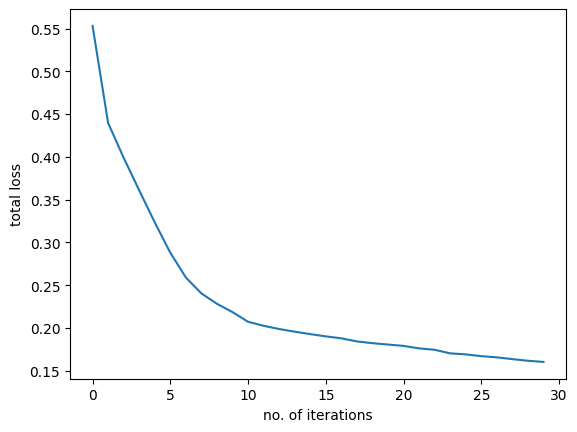

In [ ]:
plot_losses(train_losses)

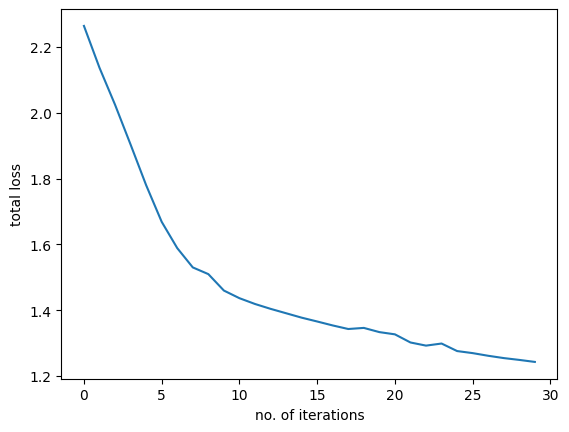

In [ ]:
plot_losses(validation_losses)

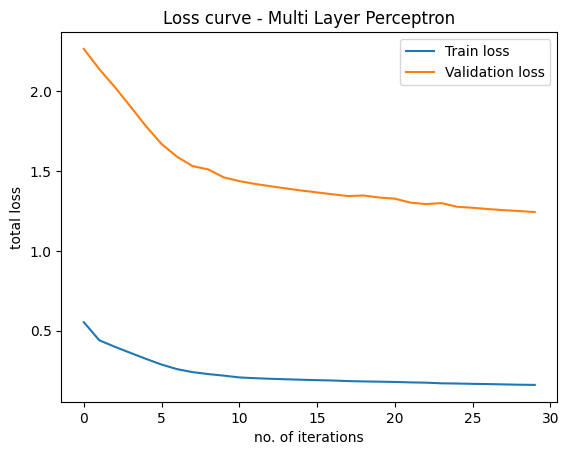

In [ ]:
plot_both_losses(range(epochs), train_losses, validation_losses)